Best Parameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
R2 Score: 0.941
MSE: 0.024


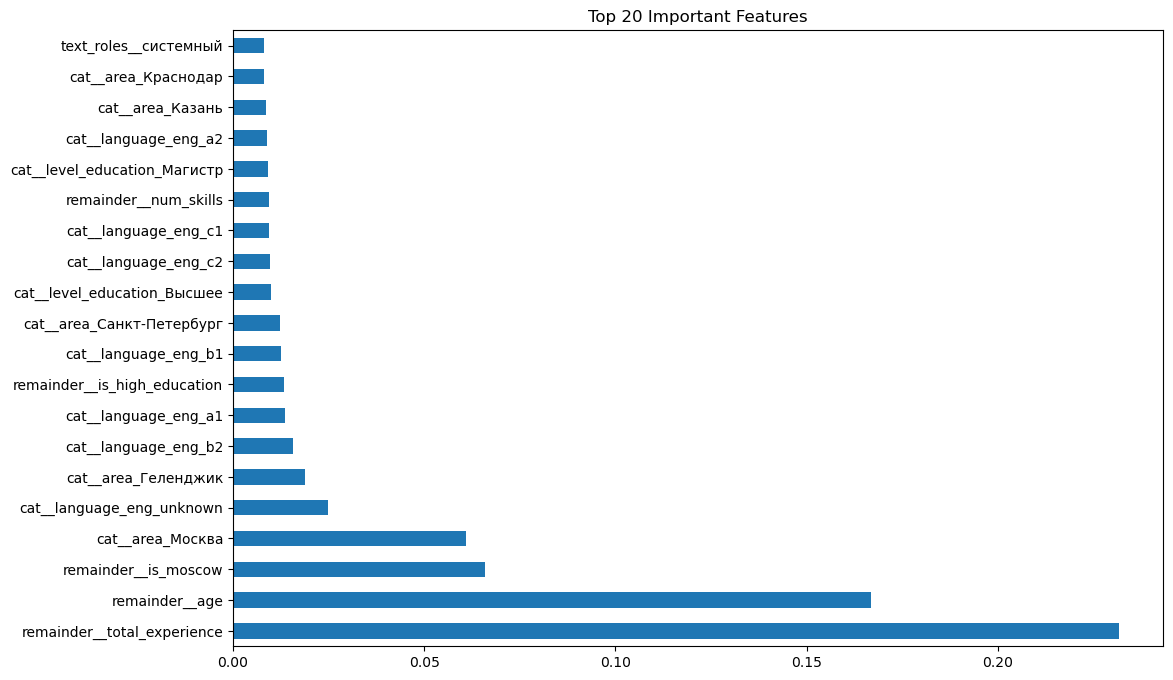

In [9]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('resume.csv')

# Удаление неиспользуемых столбцов
data = data.drop(['id_resume', 'created_at', 'updated_at', 'currency', 'salary', 'url'], axis=1)

# Обработка целевой переменной
data = data.dropna(subset=['russian_salary'])

# Удаление выбросов в зарплате (верхние 1%)
salary_q = data['russian_salary'].quantile(0.99)
data = data[data['russian_salary'] <= salary_q]

# Логарифмирование зарплаты
data['log_salary'] = np.log(data['russian_salary'])

# Функции для обработки текстовых полей
def safe_literal_eval(x):
    if pd.isna(x):
        return []
    try:
        return literal_eval(x) if isinstance(x, str) else []
    except (ValueError, SyntaxError):
        return []

def process_text_features(df):
    # Обработка skill_set
    df['skill_set'] = df['skill_set'].apply(safe_literal_eval)
    df['num_skills'] = df['skill_set'].apply(len)
    df['skill_set'] = df['skill_set'].apply(lambda x: ' '.join(map(str, x)))
    
    # Обработка professional_roles
    df['professional_roles'] = df['professional_roles'].apply(safe_literal_eval)
    df['num_roles'] = df['professional_roles'].apply(len)
    df['professional_roles'] = df['professional_roles'].apply(lambda x: ' '.join(map(str, x)))
    
    # Выделение ключевых ролей
    top_roles = ['аналитик', 'data scientist', 'developer']
    for role in top_roles:
        df[f'role_{role}'] = df['professional_roles'].str.contains(role, case=False).astype(int)
    
    return df

# Применение обработки текстовых полей
data = process_text_features(data)

# Дополнительные фичи
data['is_moscow'] = data['area'].str.contains('Москва', case=False).fillna(0).astype(int)
data['is_high_education'] = data['level_education'].isin(['Высшее', 'Магистр', 'Кандидат наук']).astype(int)

# Заполнение пропусков
data['total_experience'] = data['total_experience'].fillna(data['total_experience'].median())
data['age'] = data['age'].fillna(data['age'].median())
data['language_eng'] = data['language_eng'].fillna('unknown')

# Выбор фичей и целевой переменной
features = [
    'total_experience', 'age', 'num_skills', 'num_roles',
    'is_moscow', 'is_high_education', 'level_education',
    'area', 'language_eng', 'professional_roles', 'skill_set'
] + [col for col in data.columns if col.startswith('role_')]

X = data[features]
y = data['log_salary']  # Используем логарифм зарплаты

# Препроцессинг
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['level_education', 'area', 'language_eng']),
        ('text_roles', CountVectorizer(max_features=50), 'professional_roles'),
        ('text_skills', CountVectorizer(max_features=100), 'skill_set'),
    ],
    remainder='passthrough'
)

# Пайплайн с подбором гиперпараметров
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Параметры для GridSearch
params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

# Поиск лучших параметров
grid_search = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)

# Лучшая модель
best_model = grid_search.best_estimator_

# Оценка
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = best_model.predict(X_test)

# Метрики
print(f"Best Parameters: {grid_search.best_params_}")
print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")

# Визуализация важности признаков
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importances = best_model.named_steps['regressor'].feature_importances_
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    
    plt.figure(figsize=(12, 8))
    pd.Series(importances, index=feature_names).nlargest(20).plot(kind='barh')
    plt.title('Top 20 Important Features')
    plt.show()